# Problem 1: Modeling with ClinicalBERT Embeddings

Note: to avoid consuming the GPU resources allocated to you by colab on the parts you don't need a GPU for, make sure you use a CPU runtime (Runtime > Change Runtime Type > Hardware accelerator: None) until the notebook indicates otherwise.

## Install Libraries

In [1]:
!pip install transformers
!pip install scikit-learn
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 29.0 MB/s 
     |████████████████████████████████| 7.6 MB 53.7 MB/s 
     |████████████████████████████████| 163 kB 71.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.0 MB/s 
     |████████████████████████████████| 1.1 MB 32.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=1a36c8f0e074bc40545cd7b9953d6ffa6e77885afea7dbef1366e8a21a92594d
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=07dff52aa303544923c31401381d3d22ea1769a3b4bc9e08164aca9

## Setting up Google Drive
Copy the data at the [following link](https://drive.google.com/drive/folders/1G5NuAnUSaKzcry-tzgPZKxafG_vcOzX9?usp=sharing) to a folder in your own drive and set the path to that folder below

In [2]:
# Path to saved data
#------YOUR CODE HERE--------
data_path = "/content/drive/MyDrive/hw"
#------YOUR CODE ENDS--------

In [3]:
from google.colab import auth, drive
drive.mount('/content/drive')
auth.authenticate_user()

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import os 
import random
import sklearn
import importlib
import pickle
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time

from pathlib import Path
from torch.utils import data
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel, BertConfig, BertTokenizer, BertForMaskedLM, InputExample

pd.set_option('display.max_columns', 50)
pd.options.mode.chained_assignment = None

# Add random seed
random.seed(456)
np.random.seed(456)

(a) You can read more about ClinicalBERT [here](https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT)

In [5]:
#------YOUR CODE HERE--------
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Initialize the model
model = BertForMaskedLM.from_pretrained("emilyalsentzer/Bio_ClinicalBERT") 
#------YOUR CODE ENDS--------

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
device

device(type='cuda')

(b)

In [8]:
def fill_blank(text: str, model: BertForMaskedLM, tokenizer: BertTokenizer) -> str:
    '''
    Given a sentence with a single blank (denoted by an underscore), queries the BERT model to 
        fill in the missing token.
        
    Inputs:
        - text: sentence containing a single underscore corresponding to the missing token
        - model: pytorch ClinicalBERT model, of type BertForMaskedLM
        - tokenizer: BertTokenizer object
    
    Output:
        - string corresponding to the sentence where the underscore is replaced with the most likely token
    '''
    random.seed(456)
    np.random.seed(456)
    torch.manual_seed(456)
    
    #------YOUR CODE HERE--------
    # Replace the underscore by [MASK] and store the result in masked_str
    masked_str = text.replace("_", "[MASK]") 

    # Tokenize the masked string and store the tokens in inputs
    inputs = tokenizer(masked_str, return_tensors="pt")
    #------YOUR CODE ENDS--------

    inputs = inputs.to(device)
    model=model.to(device)
    with torch.no_grad():
        #------YOUR CODE HERE--------
        # Compute the logits (log probabilities) from the model
        logits =  model(**inputs)[0]    
        #------YOUR CODE ENDS--------

    mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]

    predicted_logits = logits[0, mask_token_index] 
    #------YOUR CODE HERE--------
    # Select the most likely token in predicted_logits
    predicted_token_id = torch.argmax(predicted_logits).item()

    # Use the tokenizer to decode the token id into a string
    pred = tokenizer.convert_ids_to_tokens([predicted_token_id])[0]
    #------YOUR CODE ENDS--------

    return text.replace('_', pred)

In [9]:
# Test fill_blank
nurse_sent = '30 yo white _ helping other nurses at the ICU'
doc_sent = '30 yo white _ helping other doctors at the ICU'
print(f"Predicted sentence: {fill_blank(nurse_sent, model, tokenizer)}")
print("Expected sentence: 30 yo white female helping other nurses at the ICU")
print(f"Predicted sentence: {fill_blank(doc_sent, model, tokenizer)}")
print("Expected sentence: 30 yo white male helping other doctors at the ICU")

Predicted sentence: 30 yo white female helping other nurses at the ICU
Expected sentence: 30 yo white female helping other nurses at the ICU
Predicted sentence: 30 yo white male helping other doctors at the ICU
Expected sentence: 30 yo white male helping other doctors at the ICU


(c)

In [10]:
#------YOUR CODE HERE--------
sent1 = 'The renal dysfunction score changes over time among the black _ population.'
sent2 = 'The cardiovascular dysfunction score changes over time among the _ women population.'
#------YOUR CODE ENDS--------
print(f"Sentence 1 (completed): {fill_blank(sent1, model, tokenizer)}")
print(f"Sentence 2 (completed): {fill_blank(sent2, model, tokenizer)}")

Sentence 1 (completed): The renal dysfunction score changes over time among the black African population.
Sentence 2 (completed): The cardiovascular dysfunction score changes over time among the elderly women population.


(d) Answer in your report

(e)

Change the runtime to GPU for this part (Runtime > Change Runtime Type > Hardware Accelerator: GPU)

In [11]:
# Load the data
df = pd.read_hdf(os.path.join(data_path, "text_and_hypertension_data.h5"))

In [12]:
def get_sent_rep(model, tokenizer, txt):
    """
    Compute the sentence representation and return it as a numpy array
    If done correctly, the numpy array should be of size 768
    """
    # Tokenize the input txt and store the result in inputs
    # Remember to set truncation=True and max_length=512
    #------YOUR CODE HERE--------
    inputs = tokenizer(txt, return_tensors="pt", truncation=True, max_length=512)
    #------YOUR CODE ENDS--------
    inputs=inputs.to(device)
    model=model.to(device)
    with torch.no_grad():
        #------YOUR CODE HERE--------
        # Compute the model outputs and store the result in outputs
        # Make sure output_hidden_states=True
        outputs = model(**inputs, output_hidden_states=True) 
        #------YOUR CODE ENDS--------
    
        embed = outputs.hidden_states[-1]

        #------YOUR CODE HERE--------
        # embed (of size [1, input_length, 768])
        # contains the hidden states corresponding to each
        # token at the final layer of the model
        # Each hidden state is a vector of size 768
        # Compute the mean of these vectors to get a representation
        # of the input sentence, and store the mean again in embed
        embed = torch.mean(embed, dim=1)
        #------YOUR CODE ENDS--------

        embed = embed.squeeze()

    return embed.cpu().detach().numpy()

The following block of code should take around 15min to run on a GPU the first time it is run. Make sure to save its result in your drive to avoid needing to run it again

In [13]:
recompute_embeds = False
# Only regenerate embeds if necessary
if not os.path.exists(os.path.join(data_path, "embeds.npy")) or recompute_embeds == True:
    # Generate embeddings
    num_pts = len(df)
    embeds = [None]* num_pts
    start = time.time()
    for row_idx in range(num_pts):
        note_data = df.iloc[row_idx]["text"]
        embeds[row_idx] = get_sent_rep(model, tokenizer, note_data)
    print(time.time() - start)
    X = np.stack(embeds, axis=0)
    with open(os.path.join(data_path, "embeds.npy"), "wb") as f:
        np.save(f, X)

(f)

You can change the runtime back to CPU to avoid using your GPU allocation

In [14]:
from sklearn.model_selection import train_test_split

# Get train and test data
with open(os.path.join(data_path, "embeds.npy"), "rb") as f:
    # X contains one embedding per row corresponding to
    # the discharge summary of the patient in that row
    # in the dataset
    X = np.load(f)

# y contains whether the patient in a particular row had
# hypertension during their ICU stay
y = df['Hypertension'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=456)

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Scale the train data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [16]:
#------YOUR CODE HERE--------
# Create and fit your logistic regression model on the training data
# Make sure to use multi_class = "multinomial" and class_weight="balanced"

LR_model = LogisticRegression(multi_class = "multinomial", class_weight="balanced", random_state=42)
LR_model.fit(X_train_scaled, y_train)


#------YOUR CODE ENDS--------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   random_state=42)

(g)

In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
#------YOUR CODE HERE--------
# Compute the performance metrics on the training set

#Compute the accuracy
train_acc = accuracy_score(y_train, LR_model.predict(X_train_scaled))
#test_acc = accuracy_score(y_test, LR_model.predict(scaler.transform(X_test)))
#precision
train_precision = precision_score(y_train, LR_model.predict(X_train_scaled), average=None)
#test_precision = precision_score(y_test, LR_model.predict(scaler.transform(X_te#st)), average=None)
# recall
train_recall = recall_score(y_train, LR_model.predict(X_train_scaled), average=None)
#test_recall = recall_score(y_test, LR_model.predict(scaler.transform(X_test)), average=None)
# F1-score 
train_f1 = f1_score(y_train, LR_model.predict(X_train_scaled), average=None)
#test_f1 = f1_score(y_test, LR_model.predict(scaler.transform(X_test)), average=None)




#------YOUR CODE ENDS--------

In [18]:
# Scale the test data
X_test_scaled = scaler.transform(X_test)

In [19]:
#------YOUR CODE HERE--------
# Compute the performance metrics on the test set

#Compute the accuracy
test_acc = accuracy_score(y_test, LR_model.predict(X_test_scaled))

#precision
test_precision = precision_score(y_test, LR_model.predict(X_test_scaled), average=None)
# recall
test_recall = recall_score(y_test, LR_model.predict(X_test_scaled), average=None)
# F1-score 
test_f1 = f1_score(y_test, LR_model.predict(X_test_scaled), average=None)



metric_dic={'Train': [train_acc, train_precision, train_recall, train_f1], 'Test': [test_acc, test_precision, test_recall, test_f1]}
metric_dic = pd.DataFrame(metric_dic, index=['Accuracy', 'Precision', 'Recall', 'F1-score']).T
display(metric_dic)


#------YOUR CODE HERE--------

,Accuracy,Precision,Recall,F1-score
Train,0.7068,"[0.7571583346231233, 0.6517101252963088]","[0.7039861850625989, 0.7104097452934662]","[0.7296047725577927, 0.6797951253973861]"
Test,0.652438,"[0.7087155963302753, 0.5892949047864128]","[0.6594110115236875, 0.6432584269662921]","[0.6831748839265973, 0.615095353209777]"


(h)

In [20]:
from umap import UMAP

In [21]:
#------YOUR CODE HERE--------
# Use UMAP to project the scaled training data onto two dimensions
# Make sure to use random_state=456
n_neighbors = 20
min_dist = .1
UMAP_model = UMAP(random_state=456, n_neighbors=n_neighbors, min_dist=min_dist,metric = 'euclidean')
train_embed = UMAP_model.fit_transform(X_train_scaled)

#------YOUR CODE ENDS--------

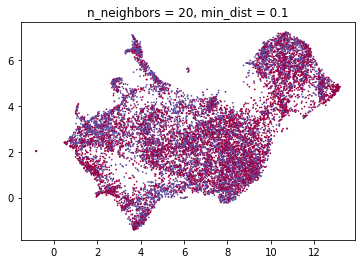

In [22]:
import matplotlib.pyplot as plt
#------YOUR CODE HERE--------
# Plot the UMAP embeddings on a scatter plot


plt.scatter(train_embed[:,0], train_embed[:,1], 
            c=y_train, 
            cmap='Spectral',
            s=.5)
plt.title("n_neighbors = {}, min_dist = {}".format(n_neighbors, min_dist))#label = ['No Hypertension', 'Hypertension']
plt.show()



#------YOUR CODE ENDS--------

In [23]:
#------YOUR CODE HERE--------
# Use UMAP to project the scaled test data onto two dimensions
# Make sure to use random_state=456
n_neighbors = 24
min_dist = .11
UMAP_model = UMAP(random_state=456, n_neighbors=n_neighbors, min_dist=min_dist,metric = 'euclidean')
test_embed = UMAP_model.fit_transform(X_test_scaled)



#------YOUR CODE ENDS--------

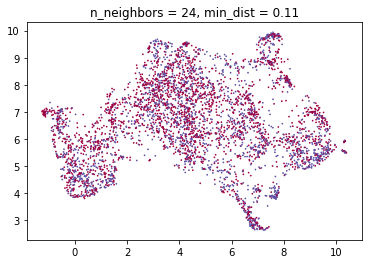

In [24]:
#------YOUR CODE HERE--------
# Plot the UMAP embeddings on a scatter plot



plt.scatter(test_embed[:,0], test_embed[:,1], 
            c=y_test, 
            cmap='Spectral',
            s=.5)
plt.title("n_neighbors = {}, min_dist = {}".format(n_neighbors, min_dist))#label = ['No Hypertension', 'Hypertension']
plt.show()



#------YOUR CODE ENDS--------

(i) Answer in your report

(j)

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [26]:
#------YOUR CODE HERE--------
# Use LDA to project the scaled training data onto a single dimension

lda_model = LinearDiscriminantAnalysis()
train_lda = lda_model.fit(X_train_scaled, y_train).transform(X_train_scaled).flatten()


#------YOUR CODE ENDS--------

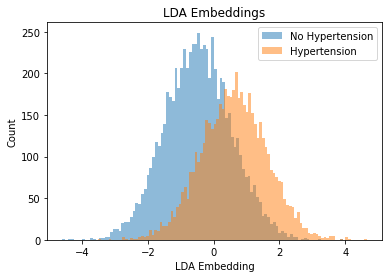

In [27]:
#------YOUR CODE HERE--------
# Plot the LDA embeddings on two histograms on the same plot
no_hyper = train_lda[np.where(np.array(y_train) == 0)]
hyper = train_lda[np.where(np.array(y_train) == 1)]

plt.hist(no_hyper, bins=100, alpha=0.5, label='No Hypertension')
plt.hist(hyper, bins=100, alpha=0.5, label='Hypertension')
plt.xlabel('LDA Embedding')
plt.ylabel('Count')
plt.title('LDA Embeddings')
plt.legend(loc='upper right')
plt.show()



#------YOUR CODE ENDS--------

In [28]:
#------YOUR CODE HERE--------
# Use LDA to project the scaled test data onto a single dimension


test_lda = lda_model.fit(X_test_scaled, y_test).transform(X_test_scaled).flatten()

#------YOUR CODE ENDS--------

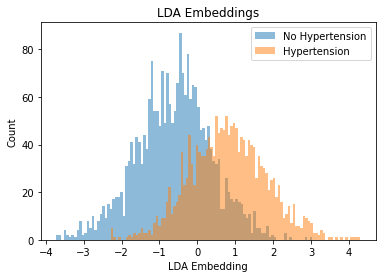

In [29]:
#------YOUR CODE HERE--------
# Plot the LDA embeddings on two histograms on the same plot


no_hyper = test_lda[np.where(np.array(y_test) == 0)]
hyper = test_lda[np.where(np.array(y_test) == 1)]

plt.hist(no_hyper, bins=100, alpha=0.5, label='No Hypertension')
plt.hist(hyper, bins=100, alpha=0.5, label='Hypertension')
plt.xlabel('LDA Embedding')
plt.ylabel('Count')
plt.title('LDA Embeddings')
plt.legend(loc='upper right')
plt.show()


#------YOUR CODE ENDS--------

(k) Answer in your report

(l) Answer in your report